# Machine Learning @ UWr 2020

**Lecture 02**

In the first note we have seen how Machine Learning deals with tasks that are defined using data.

The sequence of operations is like that:
1. We build a _training dataset_ which contains examples of the intended behavior.
2. We apply a machine learning algorithm to the _training data_. It produces a _model_, which captures the relationships in the data.
3. We use the model to answer questions about _new data_.

However, the first model we have seen, the k-Nearest Neighbors, doesn't do anything special during the learning phase - instead it simply memorizes the training data.

In this lecture, we will start exploring models that have a parametric form which is fitted using an optimization process to the data. This will feel much more like training.

## Regression on Irises

We will introduce models with parameters using the regression task. We will later generalize them to classification. For simplicity, we will continue using the Iris data, and set our goal to predict the `petal length` from `petal width`. We will once again use the implementation from `sklearn`, we will learn all the internal working of regression classifiers soon!

First, let's replot the relationship between the two variables. Please note, that this time we ignore the species of the flowers, our task is to model the relation between length and width, nothing less and nothing more.

The relationship looks nearly linear, and we can intuitively propose rule such as:
\begin{equation}
    w = \frac{ l }{3},
\end{equation}
where $w$ stands for width and $l$ stands for length.

In [1]:
# Repeat notebook initialization and data loading

import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
import seaborn as sns
import matplotlib.pyplot as plt

iris = sklearn.datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = pd.Categorical(iris.target_names[iris.target])

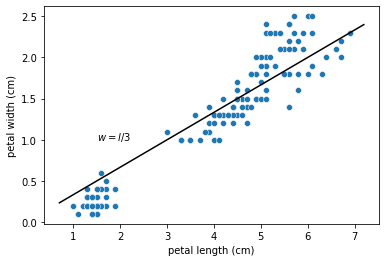

In [2]:
reg_feature='petal length (cm)'
reg_target='petal width (cm)'

# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = length_bounds / 3.0

plt.plot(length_bounds, width_predictions, color='k')
_ = plt.text(1.5, 1, "$w = l / 3$")

We can see that the guesstimated line goes roughly through the point cloud, but can we make it better?

However, we need first to say: *what does it mean better*? Machine learning requires performance benchmarks and performance measures.

Let's define them!

Our data contains pairs of examples $D={(w^{(i)}, l^{(i)})}$ with $i$ enumerating all points in the training dataset. In our case we want to /machine/ learn function mapping width $w$ to length $l$: $w\approx f(l)$. The quality of such a function must capture how close its guesses of $w$ are to the true values. For instance, we could sum the squares of the errors computed on our data:

\begin{equation}
    \text{MSE} = \frac{1}{N} \sum_{1}^{N} \left(l^{(i)} - f(w^{(i)})\right)^2.
\end{equation}

Hence, we wish to find the function $f$ that has the lowest $\text{MSE}$ error measure. 

Finally, we must define our _search space_: explicitly state what function $f$ we will be searching over. All linear mappings take the form
\begin{equation}
    w \approx f_{a,b}(l) = a\cdot l + b, 
\end{equation}
where $a$ and $b$ are some constants to be set. We indicate that $f$ is parameterized by them by using the lower index.

Thus, our task is to find such $a$ and $b$ such that MSE is minimized. Formally we write this like that:

\begin{equation}
    a^*,b^* = \underset{a,b}{\operatorname{argmin}} \frac{1}{N} \sum_{1}^{N} \left(l^{(i)} - f_{a,b}(w^{(i)})\right)^2,
\end{equation}
where the $\operatorname{argmin}$ indicates that we are returning the arguments ($a,b$) that minimize the loss function (MSE).

This optimization is what we call "fitting a model to the data": the linear regression distills all information in the data into the two parameters. Let's see it in action:

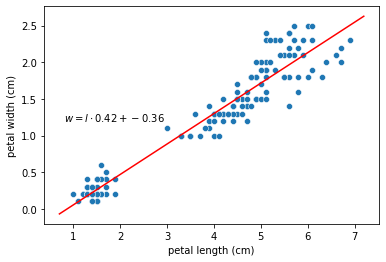

In [3]:
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(iris_df[[reg_feature]], iris_df[reg_target])

a = lin_reg.coef_
b = lin_reg.intercept_

sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = a * length_bounds + b

plt.plot(length_bounds, width_predictions, color='r')
_ = plt.text(0.8, 1.2, f"$w = l \cdot {float(a):0.2} + {float(b):0.2}$")

We can compute the error rates on the training data for both methods as follows:

In [4]:
guesstimated_mse = ((iris_df[reg_feature] / 3.0 - iris_df[reg_target])**2).mean()
linear_regression_mse = ((iris_df[reg_feature] * lin_reg.coef_ + lin_reg.intercept_ - iris_df[reg_target])**2).mean()
print(f'Guesstimated training MSE is {guesstimated_mse}, linear regression training MSE is {linear_regression_mse}')

Guesstimated training MSE is 0.06594074074074072, linear regression training MSE is 0.04206730919499317


As we can see, linear regression returns a lower MSE - it has to, because it searches for the best possible set of parameters.

## What about regression with Nearest Neighbors?

Similarly to k-NN algorithm for classification, we can formulate a k-NN algorithm for regression:
1. Given a query point x, find its k nearest neighbors $n_1, ..., n_k$
2. Return the average of the target value of the neighbors.

Let's see how it works!

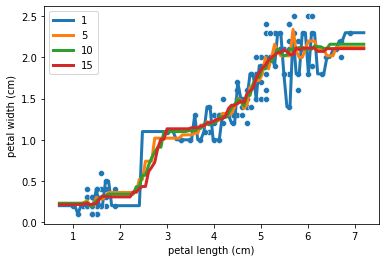

In [5]:
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
length_bounds = np.linspace(*plt.xlim(), num=100)

for k in [1, 5, 10, 15]:
    knn_reg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(iris_df[[reg_feature]], iris_df[reg_target])
    
    width_predictions = knn_reg.predict(length_bounds[:, None])  # Technicality: we must pass query points as an array
    plt.plot(length_bounds, width_predictions, linewidth=3, label=f'{k}')

plt.legend()

Similarly to classification, we can see that the larger the constant $k$, the smoother the model's predictions. Similarly to k-NN for classification, the hyperparameter $k$ should be set based on a development set.

## Internals of the Linear Regression

### Problem definition

We have gathered a dataset consisting of pairs $\{(x^{(i)}, y^{(i)}), i=1\ldots N \}$ (the upper index denotes the sample number). We want to find the relation between $x$, the *independent* variable, petal length in our example and $y$, the *dependent* variable, petal width in the example.

We will define a family of *hypotheses* (functions) parameterized by a vector of parameters $\Theta$. 

$$ y \approx f(x; \Theta). $$

To *learn* the relation between lengths and widths, or in general between $x$ and $y$, we will search the space of hypotheses (by changing the parameters $\Theta$) to find the one whose predictions best match the true targets.

We will need a *cost function* to measure the goodness of fit between hypotheses and the data. 

Finally, we will need a training (learning) algorithm that will perform the search for us.

### The hypothesis space

We will start with a simple linear family of hypotheses:
$$
f(x;\Theta) = \Theta_0 + \Theta_1 x.
$$

### The cost function

We will measure the discrepancy between predictions of a hypothesis and the true $y$ on the dataset by computing the sum of squares of errors:

$$ J(\Theta) = \frac{1}{N}\sum_{i=1}^{N} (y^{(i)}-f(x^{(i)};\Theta))^2 $$

### The training algorithm

We will now find the optimal $\Theta$ by deriving the analytical solution. However we will first generalize the problem a little, by assuming that $x$ can be a vector of values, $x=[x_1,\ldots,x_m]$. For consistency with `sklearn` we will assume that $x$ is a _row_ vector. We will also assume, that $x_0=1$. Therefore:
    
$$ f(x;\Theta) = \Theta{}_0 + \sum_{j=1}^m \Theta_j x_j = \sum_{j=0}^m \Theta_j x_j = x \Theta, $$

where $\Theta$ is a _column_ vector of parameters.

The cost function then becomes

$$ J(\Theta) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2 $$

We will make even greater use of matrix calculus. If each data sample $x$ is a vector, we can stack them into a large matrix $X \in \mathbb{R}^{N\times m}$, such that the $i$-th row of $X$ is the sample $x^{(i)}$. Likewise we will concatenate all targets $y^{(i)}$ into a matrix $Y\in\mathbb{R}^{N \times 1}$. Armed with this notation, we can compute the predictions on all data points as $X\Theta$ and compute the matrix of errors $E\in \mathbb{R}^{N \times 1}$ as:

$$ E = X\Theta - Y. $$

Finally, please note that the cost function becomes simply:

$$ J(\Theta) = \frac{1}{N}E^T E = \frac{1}{N}(X\Theta - Y)^T(X\Theta - Y) $$

We will compute the *gradient* of $J$ with respect to $\Theta$. By definition, we will assume that the gradient is also a vector of the same shape as $\Theta$. To quickly compute the gradient, we will use the matrix calculus relations described here: http://www.ee.ic.ac.uk/hp/staff/dmb/matrix/calculus.html and here: http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf:

$$ \begin{split}
\frac{\partial J(\Theta)}{\partial\Theta} &= \\ 
& \frac{\partial}{\partial\Theta} \frac{1}{N}(X\Theta - Y)^T(X\Theta - Y) =\\
&\frac{1}{N}\frac{\partial}{\partial\Theta} [\Theta^T X^T X \Theta - Y^TX\Theta - \Theta^T X^T Y + Y^TY] = \\
&\frac{1}{N}\left(2 X^T X \Theta -2 X^T Y\right) = \\
&\frac{2}{N}X^T(X\Theta - Y) = \\
&\frac{2}{N}X^T E
\end{split}$$

Solving for the zero-crossing of the derivative we obtain:

$$
\begin{align}
X^T X \Theta &= X^T Y \\
\Theta &= (X^T X) ^{-1} X^T Y 
\end{align}
$$

Please note: this is also called the Moore-Penrose pseudo-inverse of matrix $X$.

At this point, we should check whether the zero-crossing of the derivative corresponds to a minimum, maximum, or a stationary point of the loss function. We will deffer checking it to an exercise, and for now will settle the question by observing that this is a convex problem, which has a single singular point - a global optimum.

## A note about shapes and conventions

There are two conventions of interpreting a data matrix:
1. each row may be a data sample, each column denotes a feature
2. each column is a data sample, each row is a feature

Most, but not all, Python software libraries likes the first convention.

However, matrix algebra usually treats vectors as column vectors, which suggests the second option.

Whenever you read the docs for a machine learning routine, check the argument's shapes. Below we will use the first convention. Also, it helps to explicitly write vectors as matrices with one unit dimension. 



In [6]:
# X is an N by m data matrix. We add a special column of all ones
X = np.hstack((np.ones((iris_df.shape[0], 1)), iris_df[[reg_feature]]))
X[:8, :]

array([[1. , 1.4],
       [1. , 1.4],
       [1. , 1.3],
       [1. , 1.5],
       [1. , 1.4],
       [1. , 1.7],
       [1. , 1.4],
       [1. , 1.5]])

In [7]:
# Y is a column vector, represented as a Nx1 matrix
Y = iris_df[[reg_target]].values
Y[:8, :]

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.4],
       [0.3],
       [0.2]])

Recall that $\Theta = (X^T X) ^{-1} X^T Y$

In [8]:
# In Python3, @ denotes matrix multiplication
Theta = np.linalg.inv(X.T @ X) @ X.T @ Y
Theta

array([[-0.36307552],
       [ 0.41575542]])

In [9]:
# Note that the values found using the pseudo-inverse correspond to the ones 
# found by linear regression.
assert np.allclose(Theta[0,0], lin_reg.intercept_)
assert np.allclose(Theta[1,0], lin_reg.coef_)

## Overfitting, underfitting and regularization

We will now take a closer look at one of the hardest problems in Machine Learning: over- and under- fitting of models to the training set.

Recall, that our ultimate goal is to create models which work on the new, unknown data (the testing data) that we assume is similar, but not equal to the training data that we have gathered. Our model must **generalize**, or be able to find patterns on the training set which are general and which work on the test set as well.

Usually, if we do badly on training data, we also do badly on the testing data. This means that our model doesn't fit the training data, which we call **underfitting**.

However, if we do well on the training set, we may have simply remembered it, and will do badly on the test set. This is called **overfitting**.

We will now gather intuitions about these two phenomenas. We will create datasets for which we will change:
- the amount of data
- the amount of noise
- the compatibility of the data with the chosen family of hypotheses.

Towards this end, we will use polynomial regression.

### Polynomial regression

Suppose that the we have only one independent variable, $x$ and one variable to predict, $y$. Our family of hypotheses will consist of polynomials of degree $d$:
$$
f_d(x; \Theta) = \Theta_0 + x^1\Theta_1  + x^2\Theta_2  + ... + x^d\Theta_d 
$$

We can use linear regression to fit polynomials of this form, if we encode each $x$ as a vector of powers of $x$. In fact, we have already used this trick and encoded the data as two-element vectors of $1=x^0$ and $x=x^1$.

We will start by generating the datasets. The functions defining poly1 nd poly2 belong to the hypothesis family, and we should be able to detect them. On the other hand, log and sine cannot be expressed as polynomials, though we can approximate them on the domain limited to the span of the data.

In [10]:
def gen_data(N=10, sigma_noise=.2, fun='poly2'):
    X = 2 * np.random.rand(N) - 1.0
    # sort the data 
    X = np.sort(X).reshape(-1, 1)
    eps = np.random.randn(N, 1) * sigma_noise
    if fun=='poly1':
        Y = 0.3 + .7*X + eps
    elif fun=='poly2':
        Y = 0.3 + .7*X -1.1*X**2 + eps
    elif fun =='log':
        Y = np.log(X+1)**.5 + eps
    elif fun == 'sin':
        Y = np.sin(3*np.pi*X) + eps
    else:
        raise ValueError(f"Unknown fun type: {fun}.")
    if sorted:
        xind = np.argsort(X[0, :])
        X= X[:, xind]
        Y= Y[:, xind]
    return X, Y

First, let's plot the clean polynomial of degree 2.

Text(0.5, 1.0, 'The clean X-Y relation')

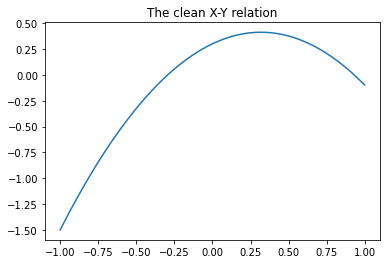

In [11]:
XC, YC = gen_data(N=1000, fun='poly2', sigma_noise=0)
plt.plot(XC, YC,'-')  # note: plot assumes that each column is a data series
plt.title('The clean X-Y relation')

Now, let's fit a model using linear regression.

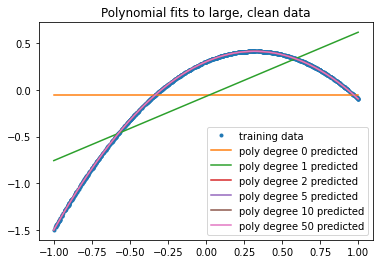

In [12]:
def expand(x, d):
    powers = np.arange(d + 1).reshape(1, -1)
    # Hint: if you don't understand this code, read about broadcasting!
    x_expanded = x.reshape(-1, 1) ** powers
    return x_expanded


class PolyRegression(sklearn.linear_model.LinearRegression):
    def __init__(self, degree):
        self.degree = degree
        # We don't fit the intercept, because we have explicitely added the 0-th power
        # of X to the expended representation.
        super().__init__(fit_intercept=False)
    
    def fit(self, x, y):
        return super().fit(expand(x, self.degree), y) 

    def predict(self, x):
        return super().predict(expand(x, self.degree)) 

plt.plot(XC, YC, '.', label='training data')
for degree in [0, 1, 2, 5, 10, 50]:
    model = PolyRegression(degree).fit(XC, YC)
    plt.plot(XC, model.predict(XC), '-', label=f'poly degree {degree} predicted')
plt.title('Polynomial fits to large, clean data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()

Without surprises we can see, that:
- polynomials of degree 0 and 1 can't fit a quadratic function
- higher order polynomials fit the data well.

However, in real world the data will often be:
- small
- noisy

Let's see what will happen in this case!

,degree,train MSE,test MSE
0,0,3.784647e-01,0.317417
1,1,1.486483e-01,0.167140
2,2,3.977033e-02,0.042425
3,3,3.338637e-02,0.112265
4,4,3.243171e-02,0.068773
5,5,2.905688e-02,0.288895
6,6,2.820077e-02,0.286091
7,7,1.339638e-02,45.134548
8,10,1.619998e-24,59754.825733
9,20,1.319752e-25,176229.981628


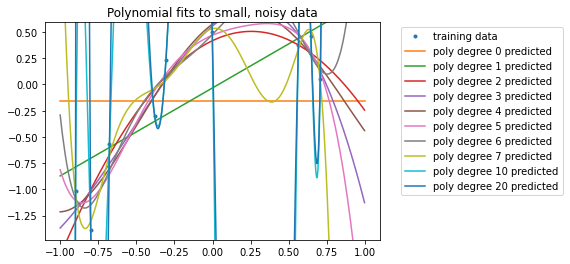

In [13]:
# Generate training and testing data. Both sets are generated from the same 
# distribution, but will be different.
# Our test set is large, to have a stable estimate of the test error
# The training data is small, to make all small-data problems more visible
np.random.seed(123)
XTe, YTe = gen_data(N=1000, fun='poly2', sigma_noise=0.2)
XTr, YTr = gen_data(N=10, fun='poly2', sigma_noise=0.2)

# Now let's fit some polynomials!
plt.plot(XTr, YTr, '.', label='training data')
ylim = plt.ylim()
errs = []
for degree in [0, 1, 2, 3, 4, 5, 6, 7, 10, 20]:
    model = PolyRegression(degree).fit(XTr, YTr)
    preds = model.predict(XTe)
    plt.plot(XTe, preds, '-', label=f'poly degree {degree} predicted')
    errs.append({'degree': degree,                  
                 'train MSE': np.mean((YTr - model.predict(XTr))**2),
                 'test MSE': np.mean((YTe - preds)**2),})
                      
plt.ylim(*ylim)
plt.title('Polynomial fits to small, noisy data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

pd.DataFrame(errs)

We can see that once again, polynomials of degree 0 and 1 underfit, but why are the high degree polynomials misbehaving? 

The problem is that they have too many parameters. A degree D polynomial can interpolate D+1 points. Thus the high degree polys will tend to fit the _noise_ on the data, and thus will loose track of the main relation in the data. We call this **overfitting**.

The issue is even more visible when we compare the MSE errors on train and test sets: on train, the MSE is always going down - higher degree polynomials fit the data better. 

However, the test MSE first go down, then climb up when the model fully interpolates the noise!

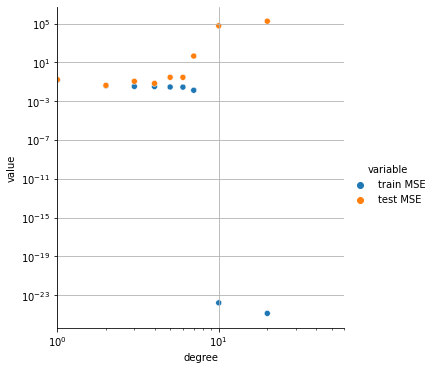

In [14]:
# This plot shows how badly the model overfits when we enter the interpolation range
sns.relplot(x='degree', y='value', hue='variable', data=pd.DataFrame(errs).melt('degree'))
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.xlim(1, 60)
plt.grid()

We can see the pattern more clearly, when we zoom in on the polynomials that can't interpolate.

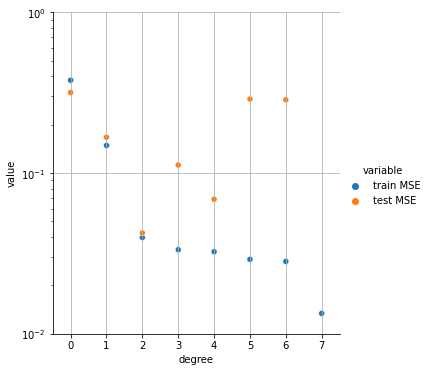

In [15]:
# This plot shows how badly the model overfits when we enter the interpolation range
sns.relplot(x='degree', y='value', hue='variable', data=pd.DataFrame(errs).melt('degree'))
plt.gca().set_yscale("log")
plt.xlim(-0.5, 7.5)
plt.ylim(1e-2, 1e0)
plt.grid()

Thus, similarly to k-NN methods, polynomial regression has a tunable hyper-parameter, the degree that has to be optimally set.

Let's now consider the other mismatch: functions, that can't be expressed with polynomials.

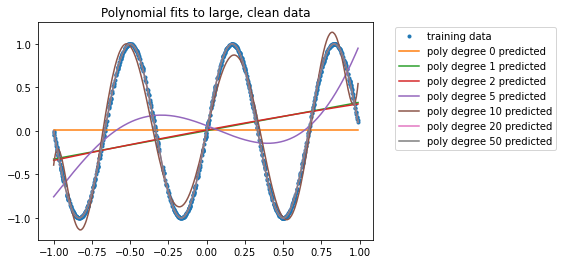

In [16]:
XC, YC = gen_data(N=1000, fun='sin', sigma_noise=0)
plt.plot(XC, YC, '.', label='training data')
for degree in [0, 1, 2, 5, 10, 20, 50]:
    model = PolyRegression(degree).fit(XC, YC)
    plt.plot(XC, model.predict(XC), '-', label=f'poly degree {degree} predicted')
plt.title('Polynomial fits to large, clean data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

While no polynomial exists which exactly fits the sine function, with a sufficiently high degree we can obtain good fits. Will we be able to find them in the presence of noise?

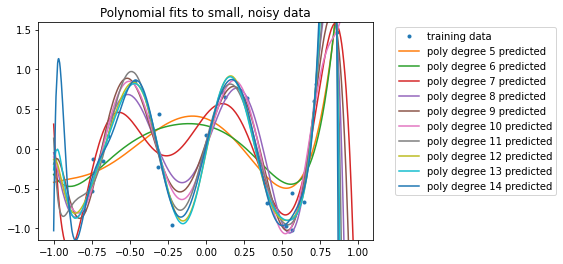

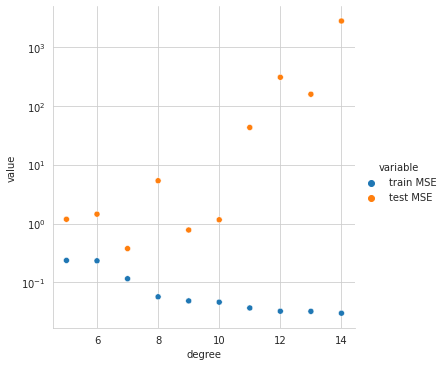

In [17]:
np.random.seed(123)
XTe, YTe = gen_data(N=1000, fun='sin', sigma_noise=0.2)
XTr, YTr = gen_data(N=25, fun='sin', sigma_noise=0.2)

# Now let's fit some polynomials!
plt.plot(XTr, YTr, '.', label='training data')
ylim = plt.ylim()
errs = []
for degree in range(5, 15):
    model = PolyRegression(degree).fit(XTr, YTr)
    preds = model.predict(XTe)
    plt.plot(XTe, preds, '-', label=f'poly degree {degree} predicted')
    errs.append({'degree': degree, 'train size': len(XTr),               
                 'train MSE': np.mean((YTr - model.predict(XTr))**2),
                 'test MSE': np.mean((YTe - preds)**2),})
                      
plt.ylim(*ylim)
plt.title('Polynomial fits to small, noisy data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

with sns.axes_style("whitegrid"):
    sns.relplot(x='degree', y='value', hue='variable', 
                data=pd.DataFrame(errs).melt(['degree', 'train size']))
    plt.gca().set_yscale("log")

In [18]:
# Print the settings for the best testing error
errs[pd.DataFrame(errs)['test MSE'].values.argmin()]

{'degree': 7,
 'test MSE': 0.37612580809615875,
 'train MSE': 0.11561670308992168,
 'train size': 25}

Similarly to the linear regression example, the higher the degree, the better the training fit. However, the best (lowest) test MSE is obtained for a degree 7 polynomial. This may be because a degree 7 poly can "bend itself" 6 times, as required by our sinus function.

However, what will happen if we use more training data?

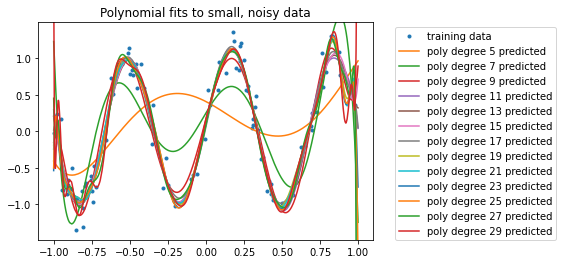

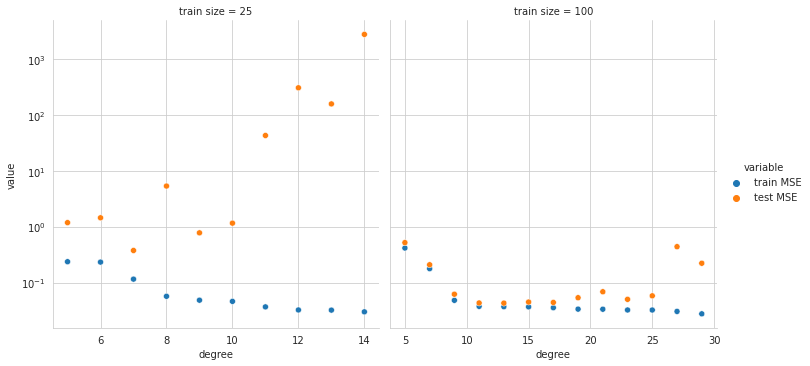

In [19]:
XTr, YTr = gen_data(N=100, fun='sin', sigma_noise=0.2)

# Now let's fit some polynomials!
plt.plot(XTr, YTr, '.', label='training data')
ylim = plt.ylim()
# errs = []  # Keep the data from previous cell
for degree in range(5, 30, 2):
    model = PolyRegression(degree).fit(XTr, YTr)
    preds = model.predict(XTe)
    plt.plot(XTe, preds, '-', label=f'poly degree {degree} predicted')
    errs.append({'degree': degree, 'train size': len(XTr),             
                 'train MSE': np.mean((YTr - model.predict(XTr))**2),
                 'test MSE': np.mean((YTe - preds)**2),})
                      
plt.ylim(*ylim)
plt.title('Polynomial fits to small, noisy data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

with sns.axes_style("whitegrid"):
    sns.relplot(x='degree', y='value', hue='variable',
                col='train size', facet_kws={'sharex': False},
                data=pd.DataFrame(errs).melt(['degree', 'train size']))
    plt.gca().set_yscale("log")

In [20]:
# Print the settings for the best testing error
errs[pd.DataFrame(errs)['test MSE'].values.argmin()]

{'degree': 13,
 'test MSE': 0.04305616567911496,
 'train MSE': 0.03720213403906034,
 'train size': 100}

We can see that with 4 times more training data, best polynomials have degrees 11-17.

## Ridge regression - more control over generalization

So far we have been able to control the strength of our polynomial regression model by choosing the degree.

However, in the general case we will be given several independent variables along with a target to predict and it is not obvious if we can remove some, or which ones to remove to control the underfitting-overfitting tradeoff. 

In upcoming lectures we will learn about selecting meaningful subsets of features. Right now, however, we will see a more fine-grained control over the behavior of the model.

Intuitively, it is fine to have many indpedent variables, as long as the model doesn't rely too much on either of them. We can achieve this by modifying our training criterion:

$$
J(\Theta) = \frac{1}{N}\sum_{i=1}^{N} \left(y^{(i)}-f(x^{(i)};\Theta)\right)^2  + \frac{\alpha}{N} \sum_j \Theta_j^2 = \text{MSE} + \text{Regularization}.
$$

We have added an extra term to the loss function! While we still care about the _testing MSE_, we have already seen that it doesn't always occurt for a model with the lowest _training MSE_. Thus, we will try to have a model which will minimize two criteria, balanced by the hyperparameter $\alpha$:
1. MSE loss, because this is what we care about
2. Regularization term, which tries to prevent the model from relying on any single input too much.

For now the regularizatoin term is intuitively heuristic, but bear with us - we will learn to interpret it more formally!

This modified variant of Linear Regression is so popular, that it has multiple names: Ridge Regression aka Tikhonov Regression, or L2 regularization, or, in deep learning, weight decay!

Below we will use the implementation from [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) but for the lab you will generalize the closed form solution to support the regularized case as well!

In [21]:
# Again, wrap sklearn's implementation to automatically expand the features
class PolyRidgeRegression(sklearn.linear_model.Ridge):
    def __init__(self, degree, alpha):
        self.degree = degree
        # We don't fit the intercept, because we have explicitely added the 0-th power
        # of X to the expended representation.
        super().__init__(alpha=alpha, fit_intercept=False)
    
    def fit(self, x, y):
        return super().fit(expand(x, self.degree), y) 

    def predict(self, x):
        return super().predict(expand(x, self.degree))

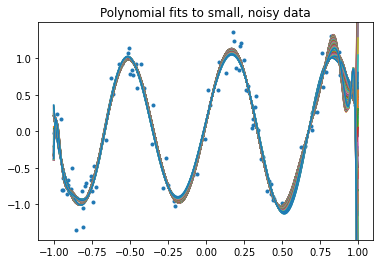

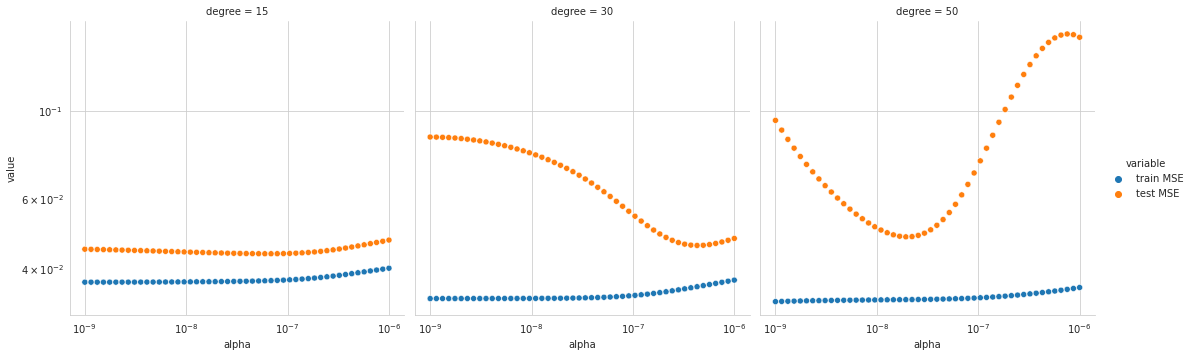

In [22]:
# Now let's fit some polynomials!
plt.plot(XTr, YTr, '.', label='training data')
ylim = plt.ylim()
errs = []  # Keep the data from previous cell
for degree in [15, 30, 50]:
    for alpha in np.logspace(-9, -6):
        model = PolyRidgeRegression(degree=degree, alpha=alpha).fit(XTr, YTr)
        preds = model.predict(XTe)
        plt.plot(XTe, preds, '-', label=f'poly alpha {alpha} predicted')
        errs.append({'degree':degree, 'alpha': alpha, 'train size': len(XTr),             
                    'train MSE': np.mean((YTr - model.predict(XTr))**2),
                    'test MSE': np.mean((YTe - preds)**2),})
                      
plt.ylim(*ylim)
plt.title('Polynomial fits to small, noisy data')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

with sns.axes_style("whitegrid"):
    sns.relplot(x='alpha', y='value', hue='variable',
                col='degree',
                data=pd.DataFrame(errs).melt(['alpha', 'degree', 'train size']))
    plt.gca().set_yscale("log")
    plt.gca().set_xscale("log")

In [23]:
# Print the settings for the best testing error
errs[pd.DataFrame(errs)['test MSE'].values.argmin()]

{'alpha': 5.963623316594637e-08,
 'degree': 15,
 'test MSE': 0.04353263193121595,
 'train MSE': 0.03718356862481422,
 'train size': 100}

We can see that on this example, adding the Ridge Regression penalty slightly improved the result, buy stabilizing the polynomial at the boundaries of the data range.

However, the main benefit of Ridge regression is stability: on the plots above we can see, that without the penalty term, polynomials of degree 27 or 29 fit badly, yielding MSE > 0.1. With the ridge penalty tuned, we can fit them to MSEs close to the one for a degree 15 polynomial.

When our data contains many independent variables, perhaps correlated, linear regression may be unstable because it reaches the interpolating regime. In such cases ridge regression will make its results more stable and predictable.

## Sidenote: Parameters, hyperparameters, what's the difference?

You might have noticed, that we have called the coefficients in linear regression the _parameters_ of a model, while we have called the number of neighbors _k_ a hyperparamer (or metaparameter). Why make such a distinction and what is their difference?

Typically, _model parameters_ are optimized on the training set. Some methods, such as _nearest neighbors_ don't have them.

On the other hand, _hyperparamters_ collectively refer to all the other decisions that we must make based on the data, such as:
- choosing a machine learning method (shall we use linear regression, or nearest neighbor regression, or a tree based model?)
- controlling the behavior of the chosen model (how many neighbors? do we want to have an intercept term? etc.)
Hyperparameetrs are usually set on the development (or validation) subsets of the data.

Hyperparameters can't be set on the test set, because this would implicitly tune the model to it, making all statistic computed on it overly optimistic. However, why can't we set the hyperparameters on the train set? The main reason is the tradeoff between achieving low errors on the training set, and low errors on new data. For instance, a linear regression model without the intercept term will have a higher train MSE that one with the intercept. Likewise, a 1-NN model will be better at classifying the training st than a 13-NN model whose decisoin boundary is much smoother. We will return to this topic in following lectures, but intuitively, the development set acts as a proxy for the test performance of our model.

## Summary

We have seen in this lecture two simple models for regression: a nearest neighbors model again predicts the new values by averaging similar data in the training dataset. Conversely, the linear regression model distills the training dataset into a single linear relation. However, we can use linear regression to learn complex relationships by expanding our data - for instance, by adding higher powers of the variables, or by adding interaction terms.

As the model gets larger, e.g. through feature expansion it becomes possible to overfit by perfectly intrpolating the training set - the model captures not only the desired relations, but also the noise in the training data. Regularization techniques, such as penalyzing the magnitude of model's parameters, can help in such cases.

Therefore, Machine Learning is an art of selecting trade-offs. As George Box famously remarked, "All models are wrong, but some are useful." Choosing the best model depends on the relations in underlying data (the model has to be relevant to it), the number of data samples, the amount of noise, etc.

This makes it both fun and challenging.